In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


In [9]:
df = pd.read_excel("q1data.xlsx").replace(-9999, np.nan)

In [69]:
plt.style.use('default')   ## reset!
plt.style.use('paper.mplstyle')

# Setup a track
def set_axis( ax, data, label, color, ls, xlim, idx, ticks=False, log=False, grid=False, alpha=1.0, lw=1.0 ) :
    global df

    if ticks :
        ax.tick_params(left = True)
        ax.set_ylabel("Depth (ft)")       
    else :
        ax.tick_params(left = False)

    
    ax.set_xlim( xlim )
    if not log :
        ax.set_xticks( np.linspace( xlim[0], xlim[1], 11 ) )

    if grid : 
        ax.grid(which='major', color='k', linewidth=.7, alpha=.4)
        ax.grid(which='minor', color='k', linestyle=':', linewidth=.5, alpha=.2)

        import matplotlib as mpl
        locmin = mpl.ticker.LogLocator(base=10.0, subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9), numticks=5)
        resX.xaxis.set_minor_locator(locmin)
        resX.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())      

    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(axis='x', colors=color)
    ax.xaxis.label.set_color(color)
    
    yc = 1.01 + idx*0.02
    ycl = yc + .010
    
    l=Line2D([0.01,.99], [yc,yc], lw=1, linestyle=ls, color=color, transform=ax.transAxes, alpha=alpha)    
    l.set_clip_on(False)
    ax.add_line( l )
    ax.text(0.01, ycl, xlim[0], horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, color=color)    
    ax.text(0.5, ycl, label, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color=color)    
    ax.text(.99, ycl, xlim[1], horizontalalignment='right', verticalalignment='center', transform=ax.transAxes, color=color)
   
    ax.plot( df[data], df['depth'], linestyle=ls, c=color, alpha=alpha, lw=lw )
    ax.set_xticklabels([])
    ax.tick_params( axis='x', which='both', bottom = False, width=0 )



Clay free, Sw=100% porosity: phi=0.125 @ 5914ft
Clay free, Sw=100%: RTW=1.629 @ 5914ft
Pure shale, Sw=100% porosity: D_Phi=0.081 @ 5933ft
Pure shale, Sw=100% porosity: N_Phi=0.121 @ 5933ft


/home/rpoli/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


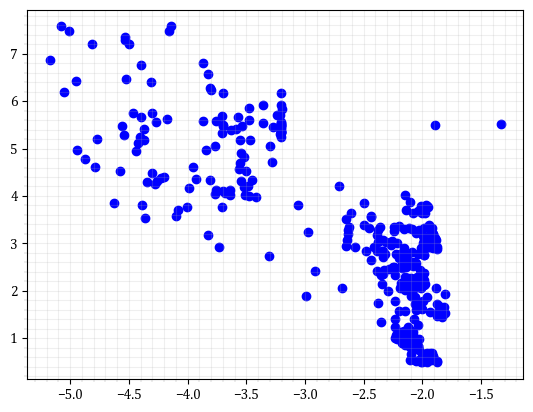

In [139]:
# Key GR measurements
GR_sh = 120
GR_s = 15

# Key depths
WOC = 5900
CLAY_FREE_SW100 = 5914
CLAY_PURE_SW100 = 5933

# Readings
PHI_SS_SW100 = np.interp( CLAY_FREE_SW100, df.depth, df["nphi-ss"] )
print(f"Clay free, Sw=100% porosity: phi={PHI_SS_SW100:.3f} @ {CLAY_FREE_SW100}ft")
RTW_SW100 = np.interp( CLAY_FREE_SW100, df.depth, df["at90"] )
print(f"Clay free, Sw=100%: RTW={RW_SW100:.3f} @ {CLAY_FREE_SW100}ft")


# Calculate dphi in % for each lithology
rhom_ss = 2.65
rhom_sh = 2.68
rhom_ls = 2.71
# dphi assuming Sw=100%
df["dphi-ss"] = (df.rhoz - rhom_ss) / ( 1 - rhom_ss )
df["dphi-ls"] = (df.rhoz - rhom_ls) / ( 1 - rhom_ls )
df["dphi-sh"] = (df.rhoz - rhom_sh) / ( 1 - rhom_sh )

# Readings of key parameters
dphi_pure_shale = np.interp( CLAY_PURE_SW100, df.depth, df["dphi-sh"] )
nphi_pure_shale = np.interp( CLAY_PURE_SW100, df.depth, df["nphi-ss"] )
print(f"Pure shale, Sw=100% porosity: D_Phi={dphi_pure_shale:.3f} @ {CLAY_PURE_SW100}ft")
print(f"Pure shale, Sw=100% porosity: N_Phi={nphi_pure_shale:.3f} @ {CLAY_PURE_SW100}ft")

## Calculations ...
df["Csh"] = ( df.gr - GR_s ) / ( GR_sh - GR_s )

# Lithology
df["sandstone"] = 0
df["limestone"] = 0
df["shale"] = 0

ss1 = ( df.depth > 5790 ) & ( df.depth < 5840 )
ss2 = ( df.depth > 5890 ) & ( df.depth < 5940 )
ls1 = ( df.depth > 5940 ) 

df.loc[ ss1 | ss2 , "sandstone" ] = 1
df.loc[ ls1 , "limestone" ] = 1
df.loc[ (df.limestone + df.sandstone == 0) , "shale" ] = 1

# Correct dphi and nphi for lithology 
df["dphi"] = 0.0
df.loc[ df.sandstone == 1, "dphi" ]  = df['dphi-ss']
df.loc[ df.limestone == 1 , "dphi" ] = df['dphi-ls']
df.loc[ df.shale == 1 , "dphi" ]     = 0 # ( df['dphi-sh'] - df.Csh * dphi_pure_shale ) / ( 1 - df.Csh )

df["nphi"] = 0.0
df.loc[ df.sandstone == 1, "nphi" ]  = df['nphi-ss']
df.loc[ df.limestone == 1 , "nphi" ] = df['nphi-ls']
df.loc[ df.shale == 1 , "nphi" ]     = 0 #( df['nphi-ss'] - df.Csh * nphi_pure_shale ) / ( 1 - df.Csh )

# Compute porosity
df["porosity"] = df.apply( lambda x : np.sqrt( x['nphi']**2/2 + x['dphi']**2/2), axis=1 )

# Water saturation - a=1, m=2, n=2
# log(Rt) = log(Rw) + log(a) - m log(phi)
df['log_r'] = np.log(df.at90)
df['log_phi'] = np.log(df.porosity)
plt.scatter( df.log_phi, df.log_r )

#df['Sw'] = np.sqrt( RW_SW100 / df.at90 ) / (df.porosity*100)
#plt.plot(df.depth, df.Sw)
# plt.plot(df.depth, df.porosity)

/home/rpoli/.local/lib/python3.10/site-packages/matplotlib/ticker.py:2920: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


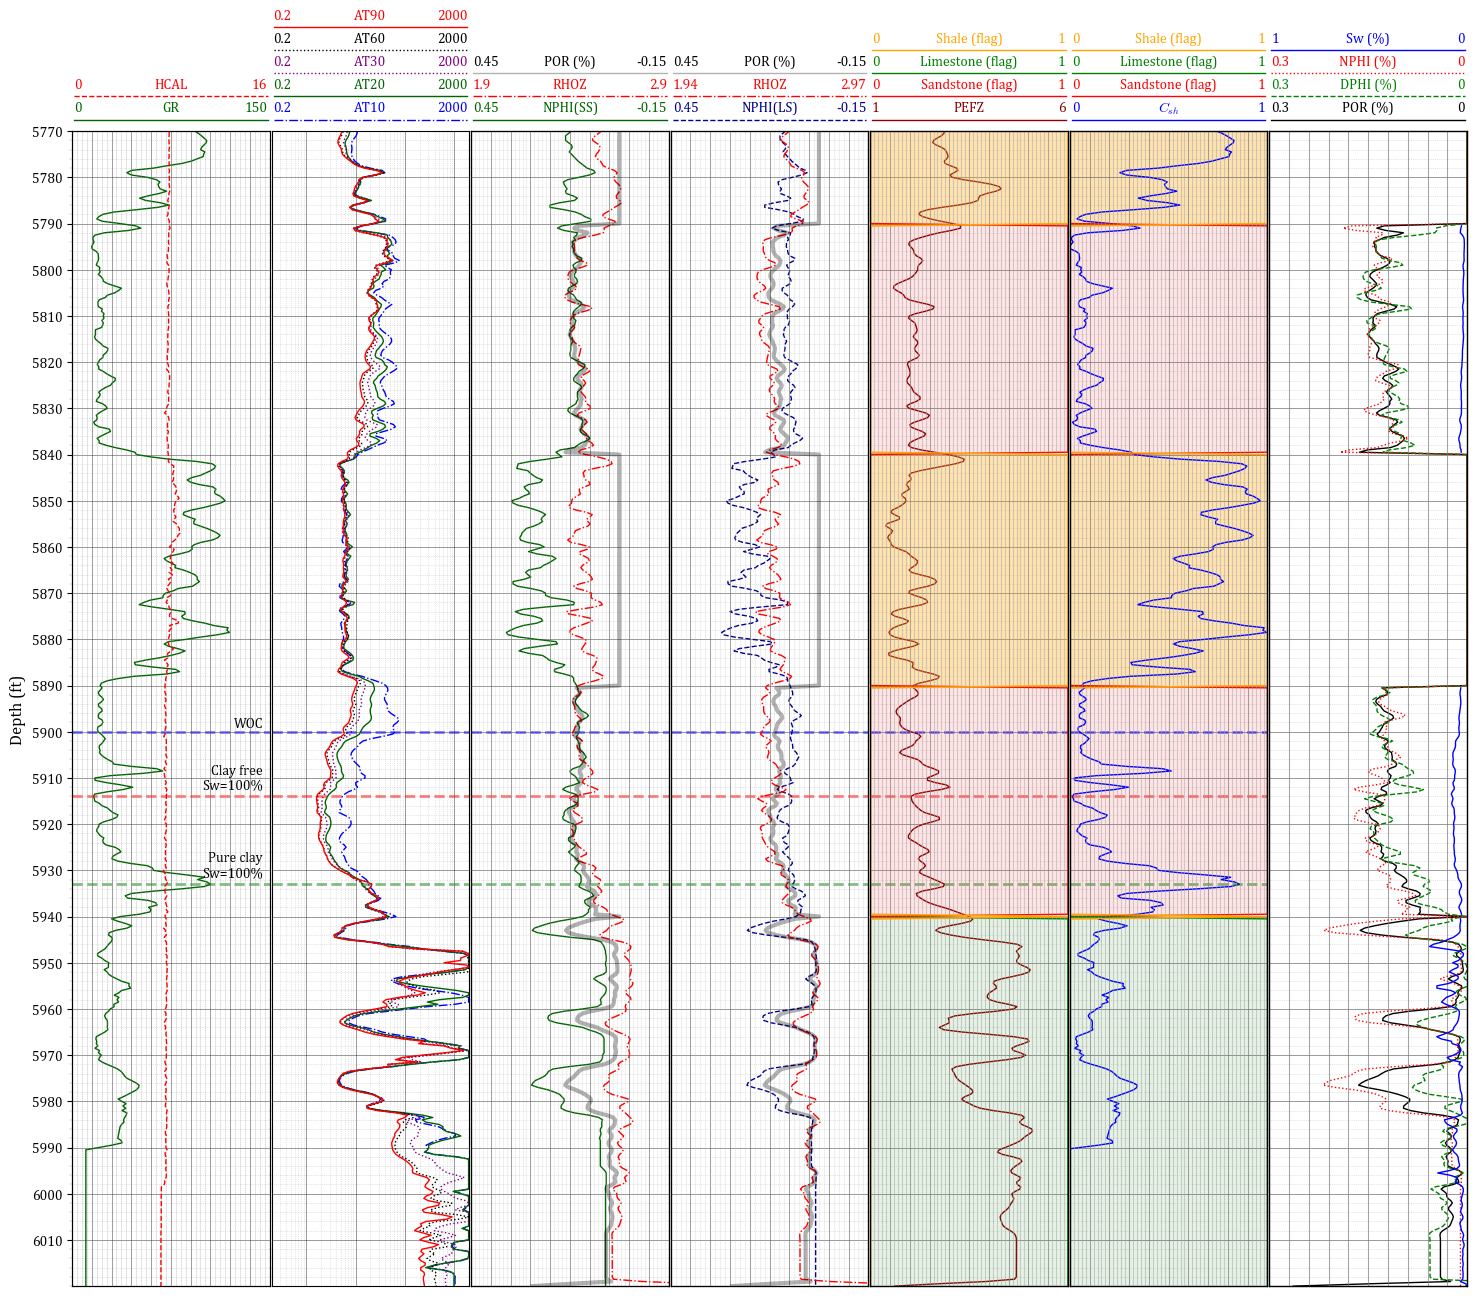

In [133]:

# Put all together
fig, [ grX, resX, ssX, lsX, pzX, cshX, porX ] = plt.subplots( 1, 7, figsize=[18,15], sharey=True)
fig.subplots_adjust(wspace=0.01, hspace=0)

# GR
set_axis( grX, 'gr', 'GR', 'darkgreen', '-', [0,150], 0, ticks=True, grid=True )
set_axis( grX.twiny(), 'hcal', 'HCAL', 'red', '--', [0,16], 1, ticks=True )

# RESISTIVITY - Manual setup of limits for resX
resX.set_xscale('log')
resX.set_xticks( [ 1, 10, 100, 1000 ] )
lims = [.2, 2000 ]
set_axis( resX, 'at10', 'AT10', 'blue', '-.', lims, 0, log=True, grid=True )
set_axis( resX, 'at20', 'AT20', 'darkgreen', '-', lims, 1, log=True )
set_axis( resX, 'at30', 'AT30', 'purple', ':', lims, 2, log=True )
set_axis( resX, 'at60', 'AT60', 'k',   ':', lims, 3, log=True )
set_axis( resX, 'at90', 'AT90', 'red', '-',  lims, 4, log=True )

# POROSITY - SANDSTONE
set_axis( ssX, 'nphi-ss', 'NPHI(SS)', 'darkgreen', '-',  [0.45,-.15], 0, grid=True )
set_axis( ssX.twiny(), 'rhoz', 'RHOZ', 'red', '-.',  [1.9,2.9], 1 )
set_axis( ssX.twiny(), 'porosity','POR (%)', 'k', '-', [0.45,-.15], 2 , alpha=.3, lw=3  )

# POROSITY - LIMESTONE
set_axis( lsX, 'nphi-ls', 'NPHI(LS)', 'darkblue', '--',  [0.45,-.15], 0, grid=True )
set_axis( lsX.twiny(), 'rhoz', 'RHOZ', 'red', '-.',  [1.94,2.97], 1 )
set_axis( lsX.twiny(), 'porosity','POR (%)', 'k', '-', [0.45,-.15], 2, alpha=.3, lw=3 )

# PEFZ
set_axis( pzX, 'pefz', 'PEFZ', 'darkred', '-',  [1,6], 0, grid=True )
litX = pzX.twiny()
set_axis( litX, 'limestone', 'Limestone (flag)', 'green', '-',  [0,1], 2 )
set_axis( litX.twiny(), 'sandstone', 'Sandstone (flag)', 'red', '-',  [0,1], 1 )
set_axis( litX.twiny(), 'shale', 'Shale (flag)', 'orange', '-',  [0,1], 3 )

litX.fill_betweenx( df.depth, df.sandstone, color='r', alpha=0.1 )
litX.fill_betweenx( df.depth, df.limestone, color='green', alpha=0.1 )
litX.fill_betweenx( df.depth, df.shale, color='orange', alpha=0.3 )


# Csh
set_axis( cshX, 'Csh', '$C_{sh}$', 'blue', '-',  [0,1], 0, grid=True )
set_axis( cshX.twiny(), 'sandstone', 'Sandstone (flag)', 'red', '-',  [0,1], 1 )
cshX.fill_betweenx( df.depth, df.sandstone, color='r', alpha=0.1 )
set_axis( cshX.twiny(), 'limestone', 'Limestone (flag)', 'green', '-',  [0,1], 2 )
cshX.fill_betweenx( df.depth, df.limestone, color='green', alpha=0.1 )
set_axis( cshX.twiny(), 'shale', 'Shale (flag)', 'orange', '-',  [0,1], 3 )
cshX.fill_betweenx( df.depth, df.shale, color='orange', alpha=0.3 )

set_axis( porX, 'porosity','POR (%)', 'k', '-', [0.3,0], 0, alpha=1, grid=True )
set_axis( porX.twiny(), 'dphi','DPHI (%)', 'green', '--', [.3,0], 1, alpha=1 )
set_axis( porX.twiny(), 'nphi','NPHI (%)', 'r', ':', [.3,0], 2, alpha=1 )
set_axis( porX.twiny(), 'Sw','Sw (%)', 'blue', '-', [1,0], 3, alpha=1 )

for ax in [ grX, resX, ssX, lsX, pzX, cshX ] :
    ax.axhline( y=WOC, lw=2, alpha=.5, ls='--', c='blue' )
    ax.axhline( y=CLAY_FREE_SW100, lw=2, ls='--', alpha=.5, c='r' )
    ax.axhline( y=CLAY_PURE_SW100, lw=2, ls='--', alpha=.5, c='GREEN' )

grX.text( 145, WOC-1, "WOC" , horizontalalignment='right') 
grX.text( 145, CLAY_FREE_SW100-1, "Clay free\nSw=100%", horizontalalignment='right', verticalalignment='bottom' ) 
grX.text( 145, CLAY_PURE_SW100-1, "Pure clay\nSw=100%", horizontalalignment='right', verticalalignment='bottom' ) 

# Configure Y axis
grX.set_ylim( 5770, 6020 )
grX.set_yticks( np.arange(5770, 6020, 10) )
grX.invert_yaxis()

fig.savefig("tracks.svg")

In [77]:
PHI_SS_SW100 = np.interp( CLAY_FREE_SW100, df.depth, df["nphi-ss"] )
print(f"Clay free, Sw=100% porosity: phi={PHI_SS_SW100:.3f} @ {CLAY_FREE_SW100}ft")
phob = ( 1 - 2.65 ) * PHI_SS_SW100 + 2.65
print(f"phob = {phob} g/cm3")
np.interp( CLAY_FREE_SW100, df.depth, df["rhoz"] )

Clay free, Sw=100% porosity: phi=0.125 @ 5914ft
phob = 2.4435091 g/cm3


2.41455

In [115]:
df

,depth,at10,at20,at30,at60,at90,gr,hcal,nphi-ss,nphi-ls,...,Csh,sandstone,limestone,shale,porosity,dphi-ss,dphi-ls,dphi-sh,dphi,nphi
0,5767.0,10.44415,7.81865,6.87851,6.37051,5.83867,97.17116,7.86807,0.134131,0.091293,...,0.782582,0,0,1,0.0,0.068127,0.100825,0.084768,0.0,0.000000
1,5767.5,10.02669,7.45335,6.55782,6.06871,5.59747,96.54652,7.87203,0.134131,0.091742,...,0.776634,0,0,1,0.0,0.072091,0.104649,0.088661,0.0,0.000000
2,5768.0,10.11977,7.41233,6.46851,5.97753,5.53381,94.72581,7.86346,0.134131,0.091760,...,0.759293,0,0,1,0.0,0.075164,0.107614,0.091679,0.0,0.000000
3,5768.5,10.66512,7.66746,6.65587,6.10768,5.65961,92.52570,7.86202,0.143115,0.098543,...,0.738340,0,0,1,0.0,0.067848,0.100556,0.084494,0.0,0.000000
4,5769.0,10.99216,7.74201,6.77958,6.05281,5.62516,91.70317,7.86202,0.140869,0.097117,...,0.730506,0,0,1,0.0,0.057303,0.090380,0.074137,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,6023.0,1027.55800,976.18030,673.27940,417.48600,241.90660,10.49291,7.19951,0.042041,0.010027,...,-0.042925,0,1,0,NaN,NaN,NaN,NaN,NaN,0.010027
513,6023.5,1029.26300,977.79970,672.80750,416.59320,241.51730,10.49291,7.19951,0.042041,0.010027,...,-0.042925,0,1,0,NaN,NaN,NaN,NaN,NaN,0.010027
514,6024.0,1034.91700,983.17100,672.51700,416.00830,241.23540,10.49291,7.19951,0.042041,0.010027,...,-0.042925,0,1,0,NaN,NaN,NaN,NaN,NaN,0.010027
515,6024.5,1041.40700,989.33690,671.69910,414.93120,240.80040,10.49291,7.19951,0.042041,0.010027,...,-0.042925,0,1,0,NaN,NaN,NaN,NaN,NaN,0.010027


In [53]:
( 1 - 2.65 ) * (-.15) + 2.65
( 1 - 2.71) * (-.15) + 2.71

2.9665